# Model
We developed a CNN-model, that classifies 150 different Pokemons in Images. The CNN-Model was built with the TensorFlow library. The code for the training ran in a notebook on the website kaggle.com. The code is shown in ./model_traing/train_model.py and the Architecture of the model is shown below. The model can be tested with images from the web by starting the script ./Pokedex.py. To test the model a .keras-file should be placed in the ./Modelle folder. 

![location model](./images/Modell_location.jpg)

With the model we achieved an accuracy of 78.1% on the test data. The Dataset contains 150 different Pokemons with 25 - 50 images each. The CNN expects input images to have a size of 160x160 pixels. The model was trained with a batch size of 16 and 50 epochs. The optimizer used was Adam with a learning rate of 0.001. The loss function used was sparse_categorical_crossentropy.

![model layers](./images/model1.jpg)

![convolution layers](./images/model2.jpg)

![dense layers](./images/model3.jpg)


# SHAP
Using SHAP, we aim to investigate:

- Which image regions the model uses for classification.
- Whether the important features differ depending on the Pokémon class.
- How the model's decisions change with targeted manipulation of the Pokémon images.

### How SHAP Works
SHAP calculates Shapley values to assess the impact of individual input features on the model's prediction. For images, SHAP identifies which pixels or regions are most important for a decision. It does this by masking image regions and analyzing the effect on the prediction.

In this project, the "blur" masker was chosen, which replaces masked image regions with blurred versions. This allows for a natural distortion of the images while preserving important structures.

## Initializing SHAP
Importing the necessary libraries SHAP

In [13]:
import numpy as np
from datasets import load_dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import shap
import requests
from io import BytesIO
import tensorflow as tf

ModuleNotFoundError: No module named 'shap'

Load trained model and data set

In [2]:
model = load_model('./Modelle/model_0.781.keras')
dataset = load_dataset("keremberke/pokemon-classification", 'full', split="train")

SHAP explainer

In [3]:
target_size = (160, 160)
image_shape = (160, 160, 3) 

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(32,32)", image_shape)

num_classes = len(dataset.features['labels'].names)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(num_classes)))

Helper functions

The analyze_image_url() function performs the following steps:
- Preprocessing of the image.
- Model prediction of the image.
- Calculation and visualization of the SHAP values.

In [4]:
image_folder = "samples/"

# Bild preprocessing
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Bild analysieren
def analyze_image(image_name):
    x_test_sample = preprocess_image(image_folder + image_name, target_size)
    
    prediction = model(np.array([x_test_sample]))
    prediction_probabilities = tf.nn.softmax(prediction).numpy()
    predicted_class_idx = np.argmax(prediction_probabilities, axis=-1)[0]
    predicted_class_name = sorted(dataset.features['labels'].names)[predicted_class_idx]
    print(f"Model Prediction: {predicted_class_name} (Class Index: {predicted_class_idx})")

    shap_values_ = explainer(np.array([x_test_sample]), max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values_)

## Analysis of the model
### Pikachu

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:24, 24.39s/it]               


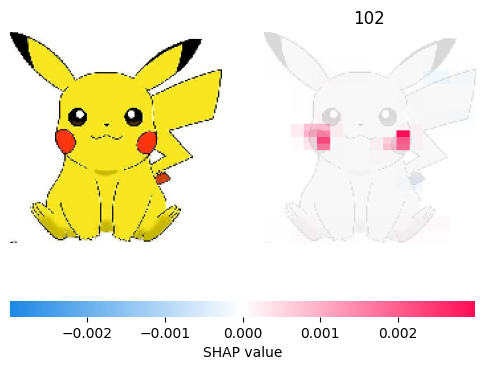

In [5]:
analyze_image("samples/pikachu.jpg")

Here you can clearly see that the most important feature for the model is the red cheeks of the Pikachu. Therefore, we will now examine how it behaves when these are no longer present.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:21, 21.38s/it]               


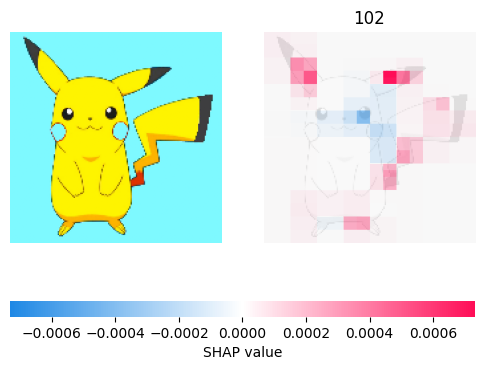

In [6]:
analyze_image("samples/pikachu_no_cheeks.jpg")

Contrary to the assumption, Pikachu is still recognized correctly. Instead, the model now focuses on the ears. However, the lower SHAP value compared to the previous plot should also be noted.
The next step is therefore to test an image without ears and tail.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:21, 21.63s/it]               


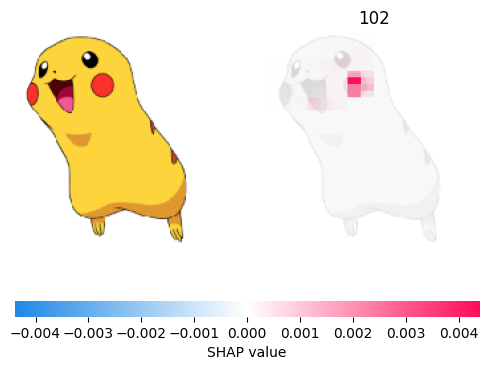

In [7]:
analyze_image("samples/pikachu_no_ears.png")

As expected, the focus is now back on the red cheeks. So these seem to be more decisive than the actually very characteristic tail or the ears, so that the model still points to Pikachu.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:22, 22.02s/it]               


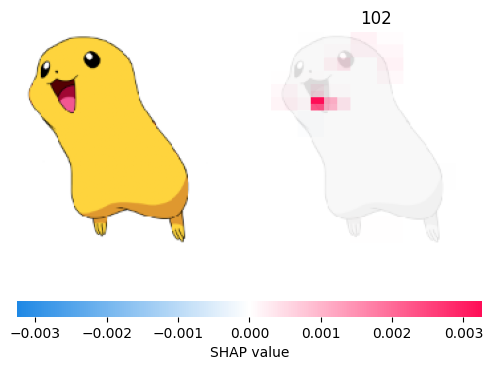

In [8]:
analyze_image("samples/pikachu_no_cheeks_ears.png")

Even without the red cheeks, Pikachu is still recognized correctly. The focus here is on the mouth.
The model therefore seems to be primarily concerned with the red color. This feature should also be taken as the last test.

Model Prediction: Psyduck (Class Index: 110)


PartitionExplainer explainer: 2it [00:21, 21.36s/it]               


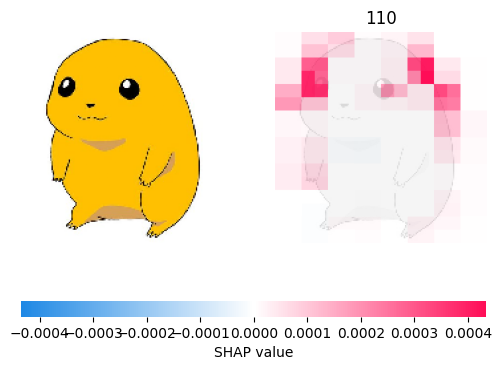

In [9]:
analyze_image("samples/pikachu_nothing.jpg")

As expected, Pikachu is no longer recognized. The removal of all characteristic features means that the model can no longer make a correct assignment.

Analysis of the various Pikachu images shows that the model is strongly focused on the red cheeks. Even if other characteristic features such as ears or tail are removed, the classification remains correct as long as the red cheeks are present. What is interesting, however, is the shift in focus to other features as soon as one feature, in this case the cheeks, is removed.

### Hitmonchan

Model Prediction: Hitmonchan (Class Index: 53)


PartitionExplainer explainer: 2it [00:21, 21.85s/it]               


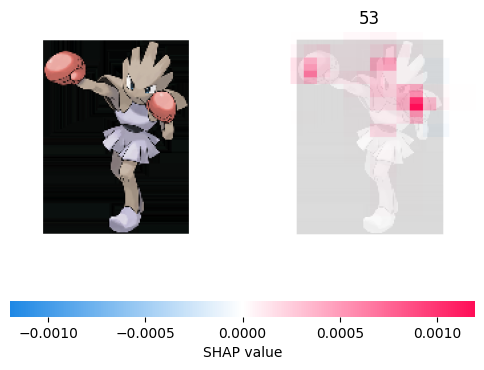

In [10]:
analyze_image("samples/hitmonchan.png")

When analyzing Hitmonchan, it becomes clear that the red boxing gloves are the most obvious feature. This will be confirmed with the next picture. 

Model Prediction: Hitmonchan (Class Index: 53)


PartitionExplainer explainer: 2it [00:21, 21.89s/it]               


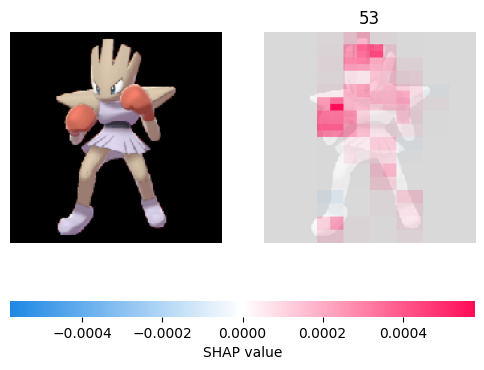

In [11]:
analyze_image("samples/hitmonchan2.png")

Despite a blurred focus, this is still largely on the red boxing glove.
Therefore, we will now test what happens when the color of this glove is changed.

Model Prediction: Mew (Class Index: 82)


PartitionExplainer explainer: 2it [00:20, 20.90s/it]               


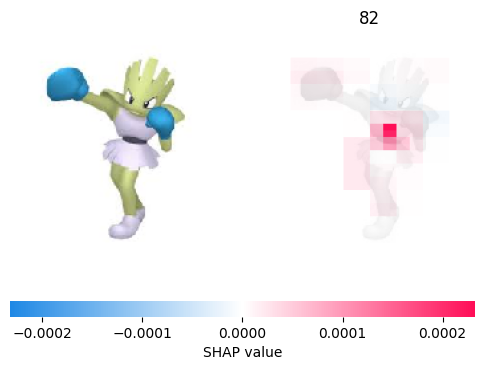

In [12]:
analyze_image("samples/hitmonchan_blue.jpeg")

In fact, this change is enough to remove the most important feature of the Pokemon from the model and thus prevent it from being recognized correctly.

### Gengar

Model Prediction: Gengar (Class Index: 41)


PartitionExplainer explainer: 2it [00:22, 22.17s/it]               


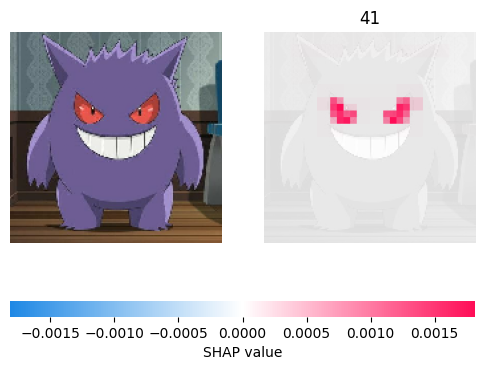

In [13]:
analyze_image("samples/gengar.jpg")

Here you can see a very clear focus on the red eyes. In the next picture, Gengar will therefore be tested with his eyes closed.

Model Prediction: Muk (Class Index: 86)


PartitionExplainer explainer: 2it [00:21, 21.29s/it]               


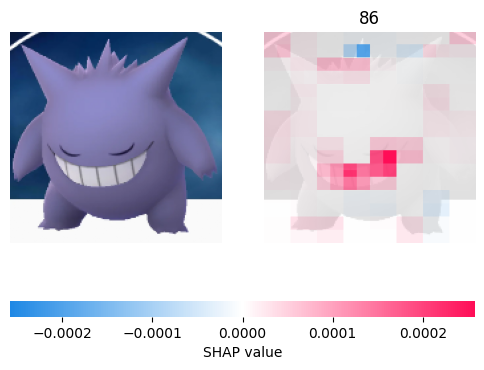

In [14]:
analyze_image("samples/gengar_closed_eyes.webp")

In fact, the closed eyes are enough to get a false result. 
In contrast to Pikachu, the other features, such as the very characteristic ears, are of little importance here.
This can be explained by the fact that the data set for Gengar consists almost exclusively of pictures with the red eyes and therefore the modell is focused on this feature.

# LIME

with LIIME we aim to investigate:
- reasons for the low accuracy of the model
- which features the model uses to distinguish similar Pokemons
- Important features for the model's decisions

## How LIME Works
LIME is a method that creates a simple and interpretable model that approximates the behavior of a complex model around a specific input. To do this, variations of the input are generated. For a CNN, pixels in an image are modified and the model’s prediction is observed to see how it changes. LIME then fits a linear model that weights each feature according to its influence on the prediction. The result shows which areas of the image are most relevant for a specific label.

The following code shows how we used LIME to explain the model's predictions for different Pokemons.


Import Libraries and create needed objects

In [1]:
import tensorflow as tf
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


#Load model
model = tf.keras.models.load_model('./Modelle/model_0.781.keras')
#Instance of the LIME explainer
explainer = lime_image.LimeImageExplainer()


function that preprocesses an image-array (normalization) and returns the model's prediction probabilities for each class

In [3]:
def model_predict(img_array):

    img_array = img_array.astype(float) / 255.0
 
    return model.predict(img_array)

This Function generates an explanation for an image classification prediction using LIME 

In [4]:
def explain_prediction(image, top_labels=1, num_features=100000, num_samples=1000):
 
    explanation = explainer.explain_instance(
        image,
        model_predict,
        hide_color=None,
        num_features=num_features,
        num_samples=num_samples,
        segmentation_fn=SegmentationAlgorithm('quickshift',
                                              kernel_size=2,
                                              max_dist=100,
                                              ratio=0.5)
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=6,
        hide_rest=True  
    )

    return explanation, temp, mask

This function displays the input image and the LIME explanation

In [5]:
def show_explanation(image, explanation_result):
    temp, mask = explanation_result
    temp = temp.astype(np.uint8)
    image = image.astype(np.uint8)
    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(temp)
    plt.title('LIME Explanation')
    plt.show()

loads image from web or local path and returns it as an array

In [6]:
def load_image_to_array(url, fromWeb, target_size=(160, 160)):
    if fromWeb:
        img = load_image_from_web(url)
    else:
        img = Image.open(url)
        
    if img is None:
        return None
    
    
    img_resized = img.resize(target_size)
    img_array = np.array(img_resized)


    if img_array.shape[-1] != 3:  
        raise ValueError("Input image must have 3 channels (RGB).")

    return img_array
    

In [7]:
from io import BytesIO
import requests

def load_image_from_web(url):  

    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        return img

    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None

combines the functions above to load an image from a local path and explain the model's prediction

In [8]:
def load_image_from_local_and_explain(url):
    image = load_image_to_array(url, False)
    explanation, temp, mask = explain_prediction(image)
    show_explanation(image, (temp, mask))    

# Examples

The following examples show some results of the investigation with LIME

# Pidgeot and Pidgeotto

Pidgeot and Pidgeotto look really similiar. One major difference are the feathers on top of their head. The following plots show that the model uses these feathers to classify the images. 

_____Pidgeot_____


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

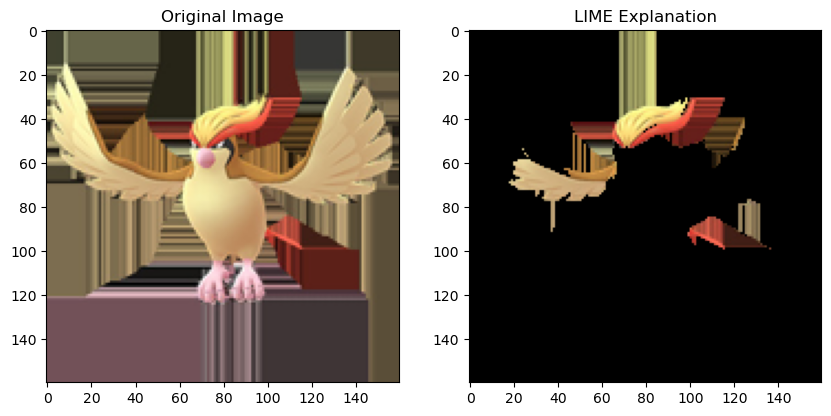

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

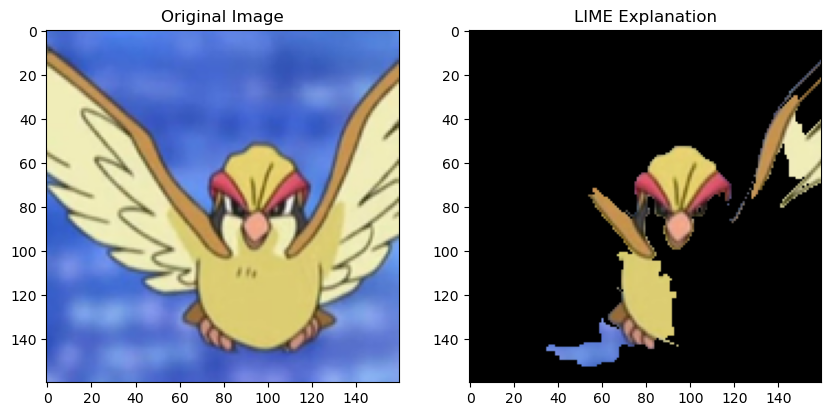

_____Pidgeotto_____


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

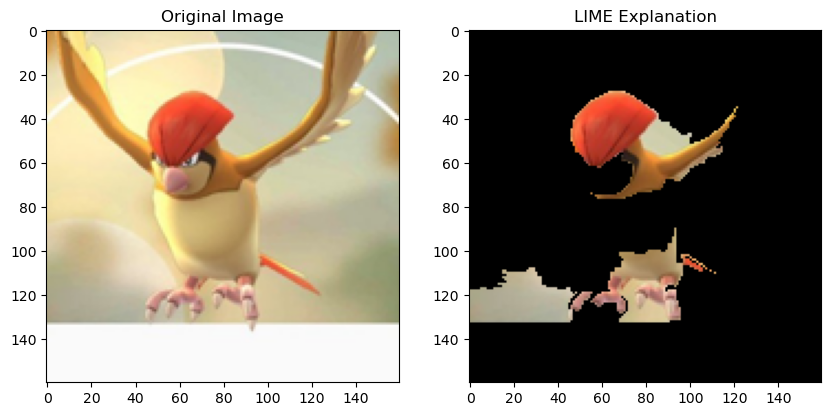

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

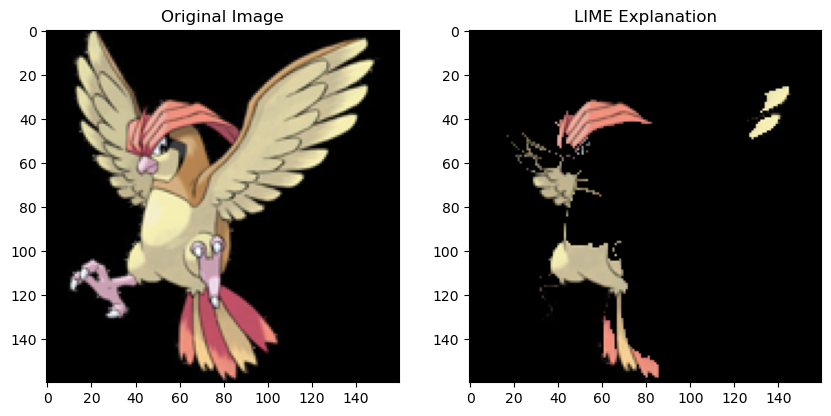

In [9]:
print("_____Pidgeot_____")
load_image_from_local_and_explain('samples/Pidgeot2.jpg')
load_image_from_local_and_explain('samples/Pidgeot3.jpg')
print("_____Pidgeotto_____")
load_image_from_local_and_explain('samples/Pidgeotto1.jpg')
load_image_from_local_and_explain('samples/Pidgeotto2.jpg')



# Aerodactyl

Aerodactyl is often falsely predicted to be Mewto. One possible reason could be the similiar skin color in some pictures.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

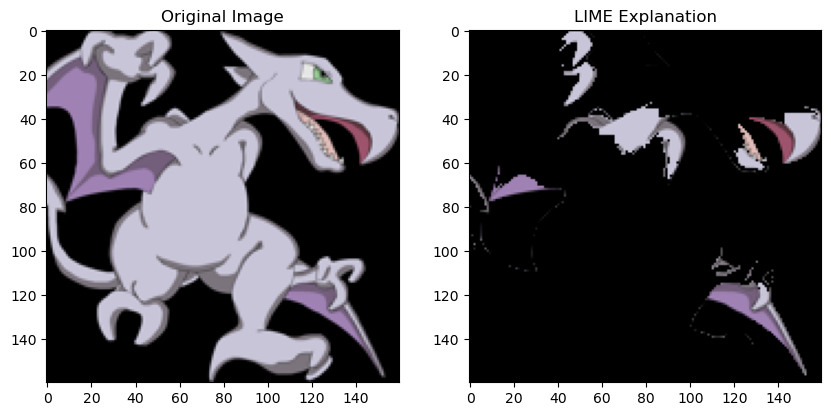

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

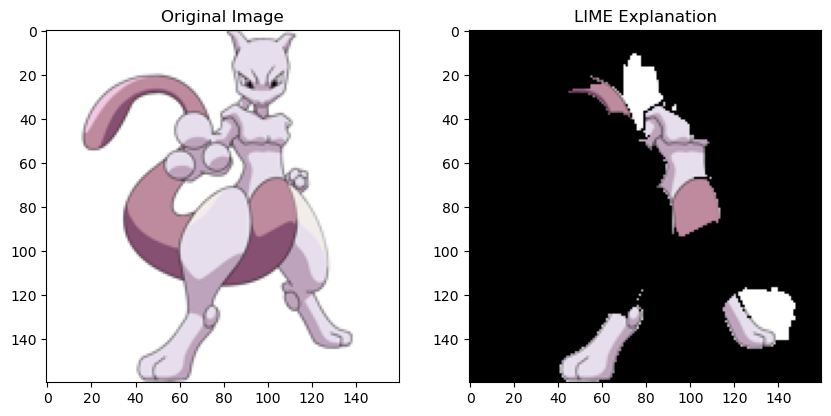

In [10]:

load_image_from_local_and_explain('samples/Aerodactyl2.jpg')
load_image_from_local_and_explain('samples/Mewtwo1.jpg')



# Clefairy and Clefable

The Pokemon Clefairy and Clefable are also very similiar. The model seems to use the spikes or wings on the back of clefable to detect clefable and tell them apart.

_____Clefairy_____


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

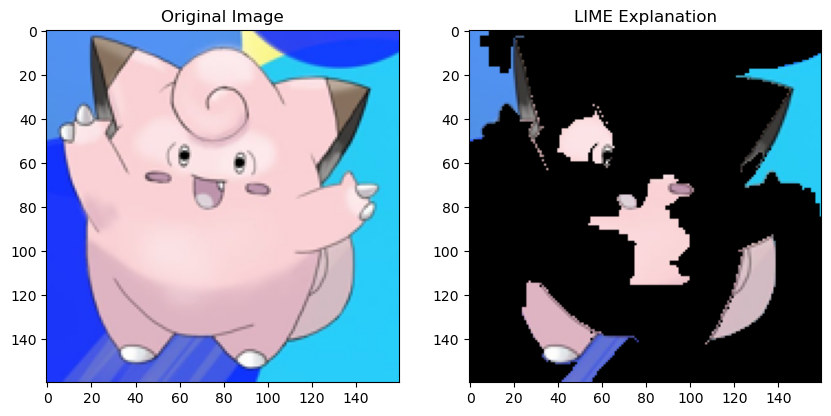

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

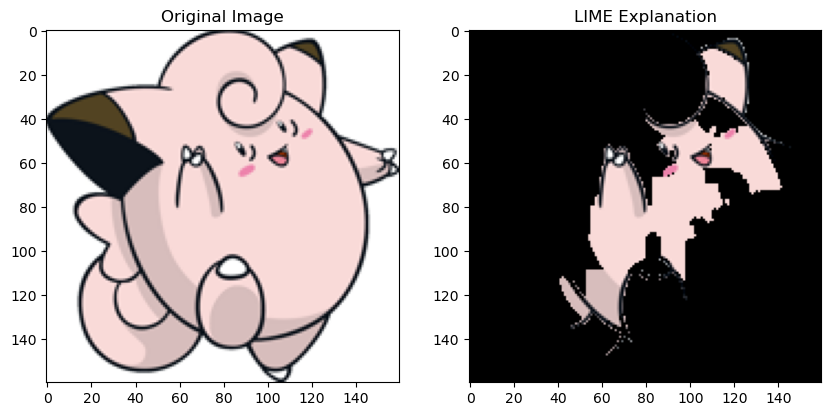

_____Clefable_____


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

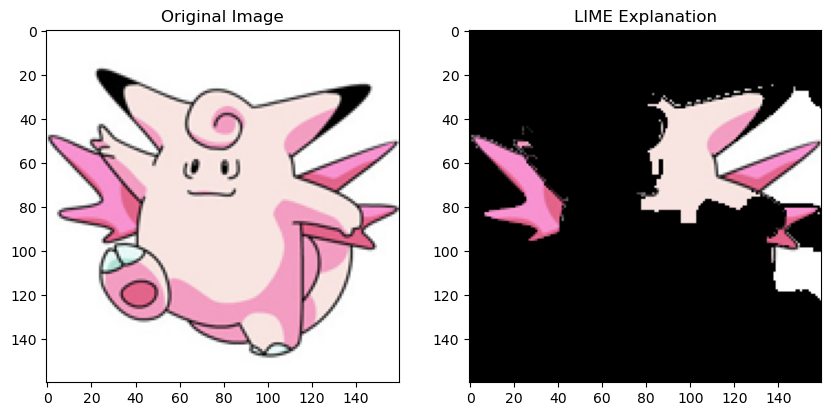

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

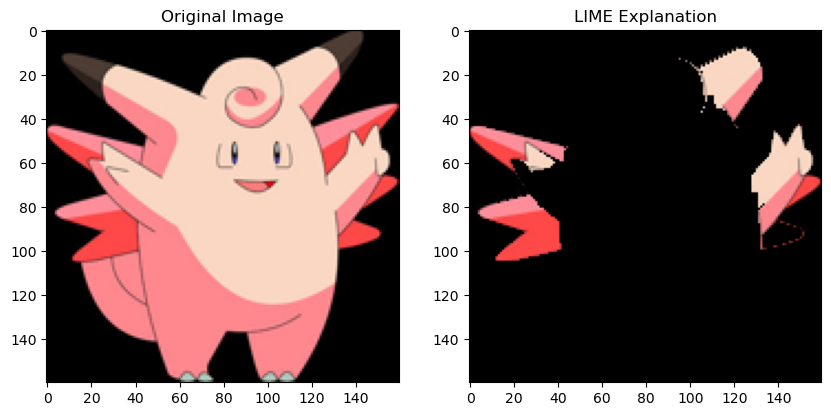

In [11]:
print("_____Clefairy_____")
load_image_from_local_and_explain('samples/clefairy1.jpg')
load_image_from_local_and_explain('samples/clefairy2.jpg')


print("_____Clefable_____")
load_image_from_local_and_explain('samples/clefable1.jpg')
load_image_from_local_and_explain('samples/clefable2.jpg')


# Cloyster

Cloyster seems to be detected by its head (pearl in the shell). If the shell is closed, the model has problems to detect Cloyster. On the second image, the shell of cloyster is closed and the model detects Nidorino instead of Cloyster.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

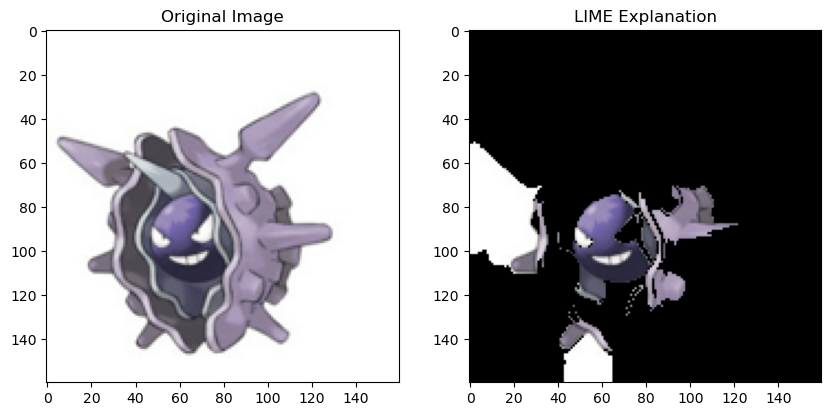

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

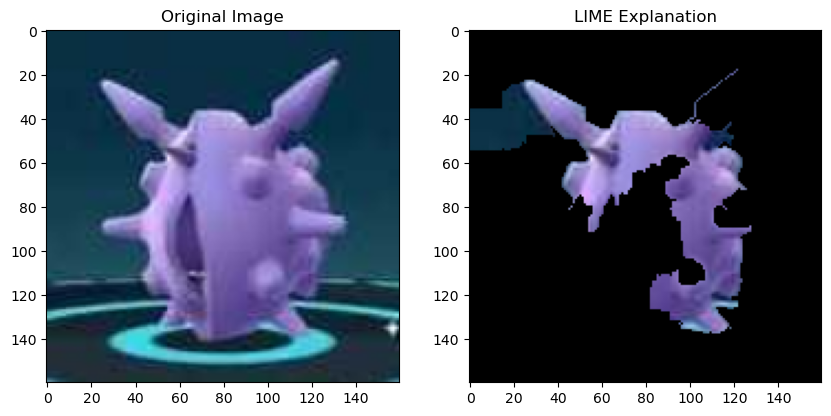

In [12]:
load_image_from_local_and_explain('samples/cloyster1.jpg')
load_image_from_local_and_explain('samples/cloyster3.jpg')

# Literature
- Ukwuoma, C. C., Cai, D., Eziefuna, E. O., Oluwasanmi, A., Abdi, S. F., Muoka, G. W., Thomas, D., & Sarpong, K. (2025). Enhancing histopathological medical image classification for early cancer diagnosis using deep learning and explainable AI – LIME & SHAP. Biomedical Signal Processing and Control, 100(Part C), 107014. https://doi.org/10.1016/j.bspc.2024.107014
- den Broeck,  G. V.;  Lykov,  A.;  Schleich,  M.;  and Suciu,  D. 2022.  On the Tractability ofSHAP Explanations.J. Artif. Intell. Res.74:  851–886. https://doi.org/10.1613/jair.1.13283.2
- Oveis, M. (2024, January 26). Easy guide: Using SHAP algorithm to explain CNN classification of SAR images (MSTAR database). Medium. https://medium.com/@oveis/easy-guide-using-shap-algorithm-to-explain-cnn-classification-of-sar-images-mstar-database-8138657585c8
- Marco Tulio Ribeiro (2016); lime package Doc; https://lime-ml.readthedocs.io/en/latest/lime.html
- del Castillo Torres; Roig-Maimó; Mascaró-Oliver, M.; Amengual-Alcover; Mas-Sansó, R. Understanding How
CNNs Recognize Facial Expressions: A Case Study with LIME and CEM. https://doi.org/10.3390/s23010131
- Marco Tulio Ribeiro, Sameer Sing, Calos Guestring; "Why Should I Trust You?": Explaining the Predictions of Any Classifier; https://dl.acm.org/doi/10.1145/2939672.2939778